<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">TM1py:</span> Data Analyis</h1>
<hr>


The first step you should complete before actually stepping through this notebook is to install all required dependencies. Assuming you already have Anaconda installed, you'll only need to install TM1py. To do this run the following commands:

<pre>pip install TM1py</pre>

The code requires an FX cube that contains data for 2017. You can run <a href="https://github.com/cubewise-code/tm1py-samples/blob/master/Samples/samples_setup.py">this script</a> to set up the cube up in your TM1 model.
In order to load the exchange rates into the cube run <a href="https://github.com/cubewise-code/tm1py-samples/blob/master/Samples/fx_rates_fred_to_cube_daily.py">this script</a> .

## Step 1: Import the Required Modules

Before we can start python'ing, we need to import a few modules that are required. 
<a href="https://code.cubewise.com/tm1py/">TM1py</a> for interacting with the TM1 API, 
<a href="https://pandas.pydata.org/">Pandas</a> for data manipulation and transformation, 
<a href="https://matplotlib.org/">matplotlib</a> for creating plots and 
<a href="https://www.xlwings.org/">xlwings</a> to interact with Excel sheets from python.

In [1]:
from TM1py.Services import TM1Service
from TM1py.Utils import Utils
import pandas as pd
import xlwings as xw
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Step 2: Setup your TM1 parameters

### TM1 Server Parameters
Define your TM1 server parameters below. In this example the script is connecting to our local TM1 instance.

In [2]:
# Server address
address = '10.77.19.10'
# HTTP port number - this can be found in your config file
port = '12354'
# username
user = 'admin'
# password
password = 'apple'
# SSL parameter - this can be found in your config file
ssl = True

## Step 3: Get TM1 Data

The following code obtains a data set from TM1 through an MDX Query. The resulting dataset is transformed into a pandas dataframe for statistical analysis.

For more on MDX Queries check out this basic <a href="https://docs.microsoft.com/en-us/sql/analysis-services/multidimensional-models/mdx/mdx-query-the-basic-query"> MDX Turoial</a> 
For more on pandas and dataframes check out this <a href="https://pandas.pydata.org/pandas-docs/stable/tutorials.html">pandas tutorial</a>.

In [3]:
# MDX Query to get the daily exchange Rates from USD to CHF in 2017
mdx = "SELECT \
NON EMPTY {[TM1py Date].[2017-01-01]:[TM1pyDate].[2017-12-31]} ON ROWS, \
{[TM1py Currency To].[CHF], [TM1py Currency To].[EUR], [TM1py Currency To].[GBP]} ON COLUMNS \
FROM [TM1py FX Rates] \
WHERE ([TM1py Currency From].[USD], [TM1py FX Rates Measure].[Spot])"

In [4]:
with TM1Service(address=address, port=port, user=user, password=password, ssl=ssl) as tm1:
    # Query data through MDX
    data = tm1.cubes.cells.execute_mdx(mdx)

    # Transform data into Pandas DataFrame
    df = Utils.build_pandas_dataframe_from_cellset(data, multiindex=True)

## Step 4: Calculate Statistical Measures

With Pandas we can do all kind of statistical analysis with our data set. In this Block we calculate statistical measures by currency pair over time.

### Standard Deviation

In [5]:
print(df.std(level='TM1py Currency To'))

                     Values
TM1py Currency To          
CHF                0.017908
EUR                0.040370
GBP                0.022367


### Median

In [6]:
print(df.median(level='TM1py Currency To'))

                     Values
TM1py Currency To          
CHF                0.986200
EUR                0.879740
GBP                0.773156


## Step 5: Plot over time with matplotlib

Plot the DataFrame with matplotlib over time.

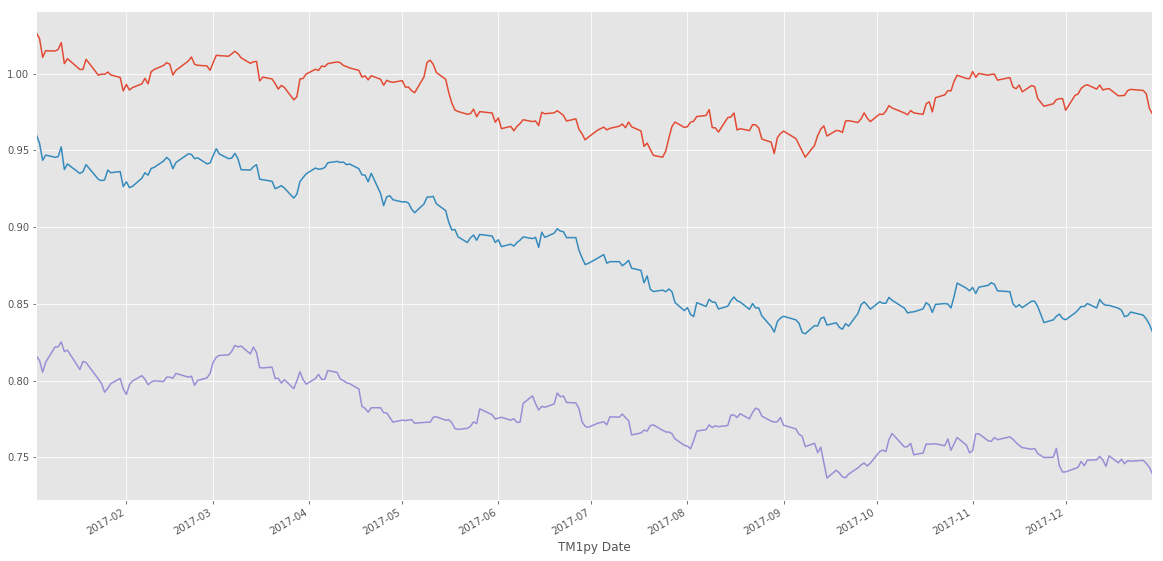

In [7]:
# Setup the Canvas
plt.rcParams['figure.figsize']=(20,10)
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 

# Manipulate DataFrame to simplify plotting
df_plot = df.unstack(level=['TM1py Currency From', 'TM1py Currency To', 'TM1py FX Rates Measure'])
df_plot.index = pd.to_datetime(df_plot.index)

# Draw graph into Canvas
df_plot.plot(legend=False, ax=ax)

## Step 6: Calculate and plot Moving Average 
Calculate and plot the Moving Average with a window of 30 days. 
USD to CHF orange, USD to EUR blue, USD to GBP violet.

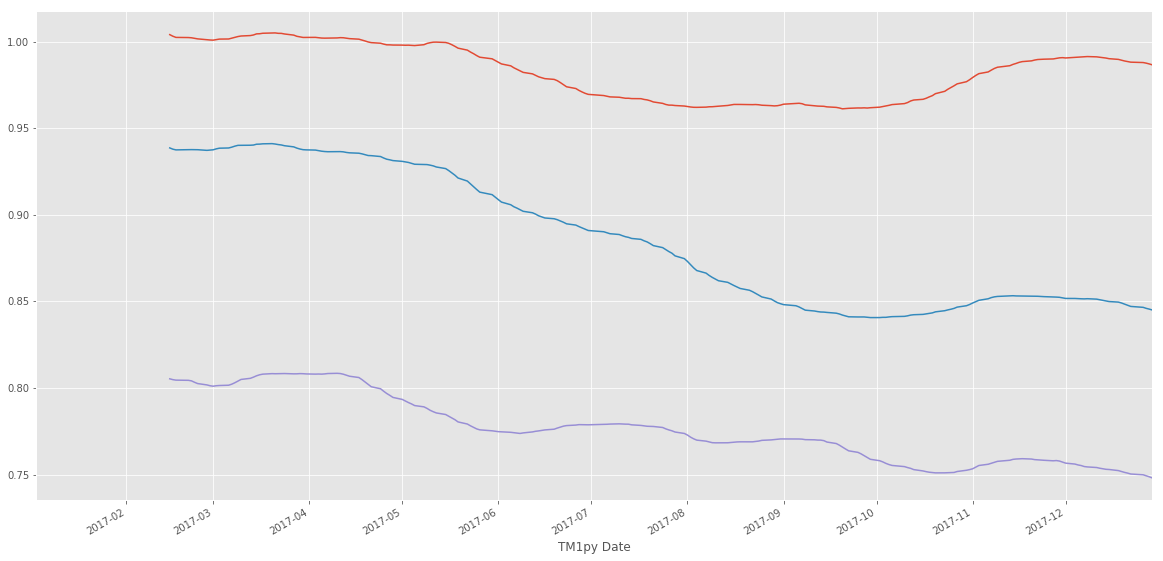

In [8]:
# Rolling 30 days Mean 
window = 30

# Setup the Canvas
plt.rcParams['figure.figsize']=(20,10)
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 

# Group by currency, calculate and draw graph into plot 
for cur, df_cur in df.groupby(level='TM1py Currency To'):
    # Manipulate DataFrame to simplify plotting
    df_cur = df_cur.unstack(level=['TM1py Currency From', 'TM1py Currency To', 'TM1py FX Rates Measure'])
    df_cur.index = pd.to_datetime(df_cur.index)
    # Draw graph into Canvas
    df_cur.rolling(window=window).mean().plot(legend=False, ax=ax)

## Step 7: Dump data to Excel with XLWings library

Dump the entire dataframe in a csv like format into Excel (starting at cell A1). Requires Excel to be open!

In [9]:
xw.Range('A1').value = df

## Step 8: Dump Chart to Excel Sheet

Dump the plot as an image into your Excel Sheet. Requires Excel to be open!

In [10]:
xw.sheets.active.pictures.add(fig, name="2017 USD to CHF, EUR and GBP")

<Picture '2017 USD to CHF, EUR and GBP' in <Sheet [Book1]Sheet1>>